# Trabalho 2 - Cálculo Numérico

Artur De Vlieger Lima (13671574)

Gabriel da Costa Merlin (12544420)

In [66]:
# Importando bibliotecas usadas
import numpy as np
import gdown
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d

## Exercício 1

### a)

Como pedido, fizemos uma função para aproximar os autovalores de uma matriz usando o método de Francis. Isso será essencial para que o nosso SVD funcione

In [67]:
def francis(A, tol):
    n = A.shape[0]
    V = np.eye(n)
    erro = np.inf

    while erro > tol:
        (Q, R) = np.linalg.qr(A)
        A = R @ Q
        V = V @ Q
        erro = np.max(abs(np.tril(A,-1)))

    D = np.diag(A)

    return V, D

### b)

Fizeos uma decomposição SVD, usando o método de Francis para encontrar a matriz V e a D, e manipulando a fórmula
$$  A = U · Σ · V^T $$
encontramos a matriz U faltante


In [68]:
def svd(A, tol):
    m, n = A.shape
    k = min(m, n)
    S = np.zeros((m, n))
    # Usamos o At @ A para achar o V e D
    V, D = francis(A.T @ A, tol)
    # Notamos problemas de aproximação do pytho que tornava alguns numeros negativos,
    # o que não deveria acontecer
    D = np.abs(D)
    # O sigma(autovalores) é a raiz quadrada de D)
    S[:k, :k] = np.diag(np.sqrt(D))

    # Usamos a fórmula vista na teoria para não ter que usar o francis novamente,
    # algo que aumentaria o erro do nosso código e levaria muito tempo para rodar
    invers_S = np.diag(1 / np.diag(S[:k, :k]))

    U = A @ V @ invers_S

    return U, S, V

### c)

Agora vamos testar o funcionamento do SVD para a imagem abaixo do gato

In [69]:
# Baixando imagem que será usada no SVD
url = "https://drive.google.com/file/d/1QVNg_V_D6OvCRlNp0fqtSrcGZchocDvd/view?usp=sharing"
output = "img.png"
gdown.download(url, output, quiet=False, fuzzy=True)

Downloading...
From: https://drive.google.com/uc?id=1QVNg_V_D6OvCRlNp0fqtSrcGZchocDvd
To: /content/img.png
100%|██████████| 19.5k/19.5k [00:00<00:00, 26.5MB/s]


'img.png'

Imagem original

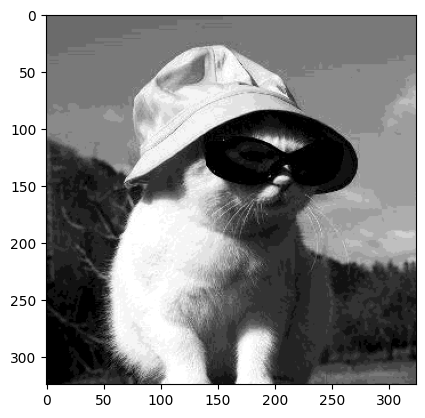

In [70]:
image = plt.imread('./img.png')

plt.imshow(image[:, :, 0], cmap='gray')

Aplicando o SVD com tolerância de 1e-3, podemos ver que a imagem foi reconstruída perfeitamente, pelo menos a olho nu, mas subtraindo as matrizes da imagem pode-se notar uma pequena diferença

In [71]:
tol = 1e-3
k =min(image[:,:,0].shape)
U, S, V = svd(image[:,:,0], tol)
# Verificando se a decomposição está correta
reconstructed_image = U[:,:k]@S[:k,:k]@V[:,:k].T

Imagem reconstruída

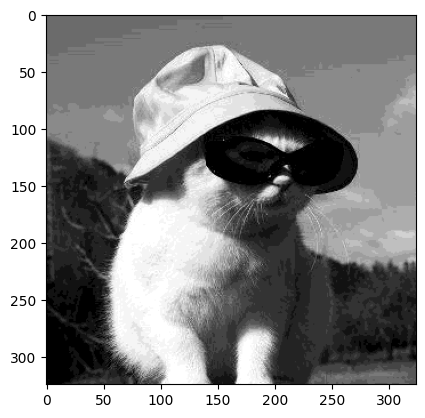

In [72]:
plt.imshow(reconstructed_image, cmap='gray')

Diferença entre as matrizes imagens

In [73]:
print(np.linalg.norm(image[:,:,0] - reconstructed_image))

3.053481011810639e-05


Também utilizamos o método já pronto do numpy.linalg, a primeira coisa que notamos é que ele roda muito mais rápido que o nosso, mas o nosso pelo menos a diferença entre os valores da imagem original e reconstruída foi menor ao menos para essa imagem

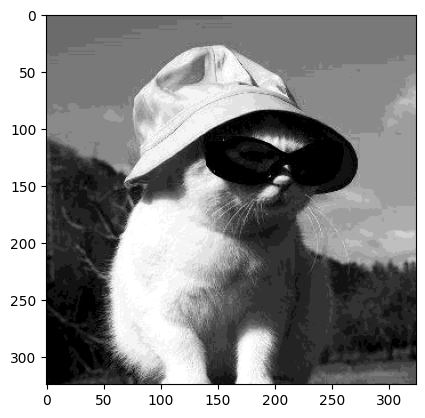

In [74]:
u,s,v = np.linalg.svd(image[:,:,0])
svd_image = u[:,:k]@np.diag((s))[:k,:k]@v[:,:k]
plt.imshow(svd_image, cmap='gray')

In [75]:
print(np.linalg.norm(image[:,:,0] - svd_image))

5.0039707e-05


E agora, a magia do SVD acontece, podemos usar apenas os autovalores mais importantes para reconstruir a imagem, conseguindo assim guardar menos dados(comprimi-la), mas gerar uma imagem muito semelhante a original.

Abaixo, temos usando 50% de compressão e 70% de compressão, note que a qualidade da imagem cai um pouco, mas ainda assim, por conseguirmos reduzir o espaço de armazenamento de $$ m * n$$ para $$k * (m + n + 1)$$, vale a pena dependendo da aplicação

80

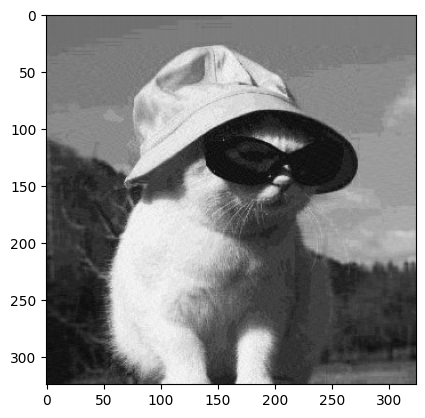

In [76]:
# Imagem original de tamanho n * m
# Imagem nova de tamanho k * (m + n + 1)
# Se queremos 50% de compressão, k * (m + n + 1) = 0.5 * (m*n)
m = image.shape[0]
n = image.shape[1]
k_50 =int(((m * n) * 0.5) / (m + n + 1))
plt.imshow(U[:,:k_50]@S[:k_50,:k_50]@V[:,:k_50].T, cmap='gray')
k_50

48

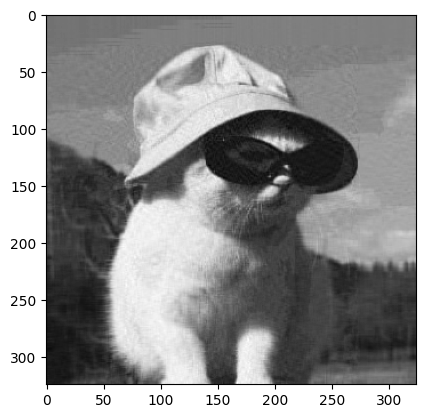

In [77]:
# Imagem original de tamanho n * m
# Imagem nova de tamanho k * (m + n + 1)
# Se queremos 70% de compressão, k * (m + n + 1) = 0.3 * (m*n)
k_70 =int(((m * n) * 0.3) / (m + n + 1))
plt.imshow(U[:,:k_70]@S[:k_70,:k_70]@V[:,:k_70].T, cmap='gray')
k_70

## Exercício 2

### a)

In [78]:
def lagrange_interp(xi, yi, x):
  n = np.size(xi)  # Número de pontos de dados
  m = np.size(x)   # Número de pontos onde queremos avaliar o polinômio

  L = np.ones((n, m))

  for i in range(n):
    for j in range(n):
      if i != j:
        # Atualiza os polinômios de Lagrange
        L[i, :] = (L[i, :] * (x - xi[j])) / (xi[i] - xi[j])

  y = yi.dot(L)  # Calcula os valores interpolados multiplicando pelos yi
  return y

def newton_interp(xi, yi, x):
  n = np.size(xi)  # Número de pontos de dados
  ni = np.size(x)  # Número de pontos onde queremos avaliar o polinômio

  N = np.ones((n, ni))
  D = np.zeros((n, n))
  D[:, 0] = yi  # Primeira coluna das diferenças divididas são os yi

  # Calcula as diferenças divididas
  for j in range(n - 1):
    for i in range(n - j - 1):
      D[i, j + 1] = (D[i + 1, j] - D[i, j]) / (xi[i + j + 1] - xi[i])

  # Calcula os termos de Newton
  for i in np.arange(1, n):
    N[i, :] = N[i - 1, :] * (x - xi[i - 1])

  y = D[0, :].dot(N)  # Calcula os valores interpolados usando diferenças divididas e termos de Newton
  return y

### b)

In [79]:
# Função real
def f(x):
    return 1 / (1 + 25 * (x ** 2))

In [80]:
# Calculando 100 pontos entre -1 e 1 da função real (f)
xTeste = np.linspace(-1, 1, 100)
yFuncao = f(xTeste)

In [81]:
# Calculando a interpolação de Newton e Lagrange usando 11 pontos entre -1 e 1
xi = np.linspace(-1, 1, 11)
yi = f(xi)

y11Newton = newton_interp(xi, yi, xTeste)
y11Lagrange = lagrange_interp(xi, yi, xTeste)

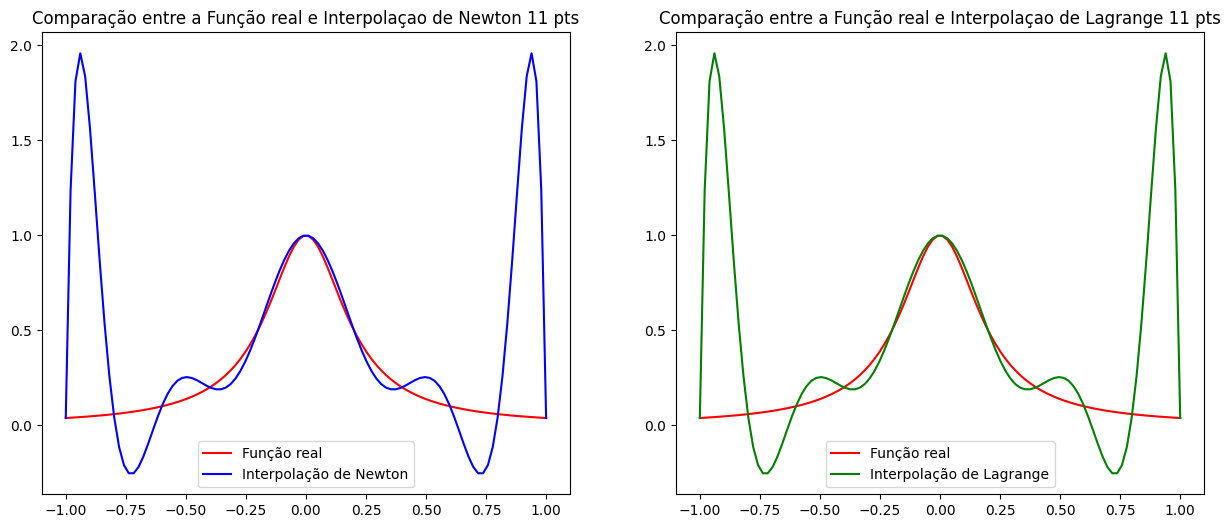

In [82]:
# Gráficos comparando os dois métodos de interpolação
fig, axis = plt.subplots(1, 2, figsize=(15, 6))

axis[0].set_title('Comparação entre a Função real e Interpolaçao de Newton 11 pts')
axis[0].plot(xTeste, yFuncao, 'r', label='Função real')
axis[0].plot(xTeste, y11Newton, 'b', label='Interpolação de Newton')
axis[0].legend()

axis[1].set_title('Comparação entre a Função real e Interpolaçao de Lagrange 11 pts')
axis[1].plot(xTeste, yFuncao, 'r', label='Função real')
axis[1].plot(xTeste, y11Lagrange, 'g', label='Interpolação de Lagrange')
axis[1].legend()

Tanto a interpolação de Lagrange quanto a de Newton são métodos para obter o polinômio interpolador que passa exatamente pelos pontos fornecidos. A teoria que explica a igualdade das duas soluções baseia-se na unicidade do polinômio interpolador. Para um conjunto de N+1 pontos distintos, existe um único polinômio de grau N que passa por todos esses pontos. Portanto, apesar das diferentes abordagens de construção, ambos os métodos produzem o mesmo polinômio interpolador.

### c)

In [83]:
# Calculando a interpolação de Newton e Lagrange usando 21 pontos entre -1 e 1
xi = np.linspace(-1, 1, 21)
yi = f(xi)

y21Newton = newton_interp(xi, yi, xTeste)
y21Lagrange = lagrange_interp(xi, yi, xTeste)

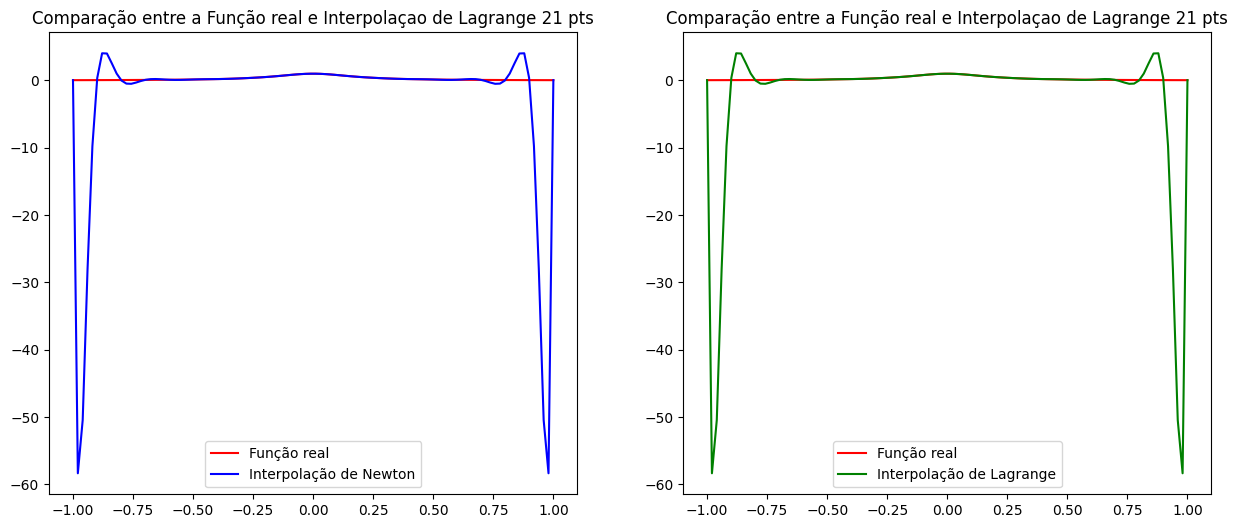

In [84]:
# Gráficos comparando os dois métodos de interpolação
fig, axis = plt.subplots(1, 2, figsize=(15, 6))

axis[0].set_title('Comparação entre a Função real e Interpolaçao de Lagrange 21 pts')
axis[0].plot(xTeste, yFuncao, 'r', label='Função real')
axis[0].plot(xTeste, y21Newton, 'b', label='Interpolação de Newton')
axis[0].legend()

axis[1].set_title('Comparação entre a Função real e Interpolaçao de Lagrange 21 pts')
axis[1].plot(xTeste, yFuncao, 'r', label='Função real')
axis[1].plot(xTeste, y21Lagrange, 'g', label='Interpolação de Lagrange')
axis[1].legend()

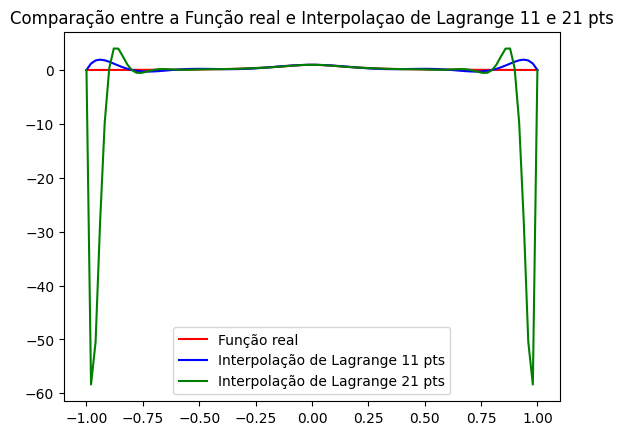

In [85]:
plt.title('Comparação entre a Função real e Interpolaçao de Lagrange 11 e 21 pts')
plt.plot(xTeste, yFuncao, 'r', label='Função real')
plt.plot(xTeste, y11Lagrange, 'b', label='Interpolação de Lagrange 11 pts')
plt.plot(xTeste, y21Lagrange, 'g', label='Interpolação de Lagrange 21 pts')
plt.legend()

Ao utilizar mais pontos (21 em vez de 11), estamos aumentando a complexidade do polinômio interpolador. Contudo, isso pode resultar no fenômeno conhecido como oscilações de Runge. Esse fenômeno ocorre ao usar polinômios de alta ordem para interpolar dados igualmente espaçados, levando a oscilações significativas nas extremidades do intervalo. Em outras palavras, não há garantia de que o polinômio obtido pela interpolação converge para a função real à medida que a ordem do polinômio tende ao infinito.

### d)

In [86]:
# Calculando a interpolação com splines usando 21 pontos entre -1 e 1
xi = np.linspace(-1, 1, 21)
yi = f(xi)

interpLinear = interp1d(xi, yi, kind='linear')
interpCubica = interp1d(xi, yi, kind='cubic')

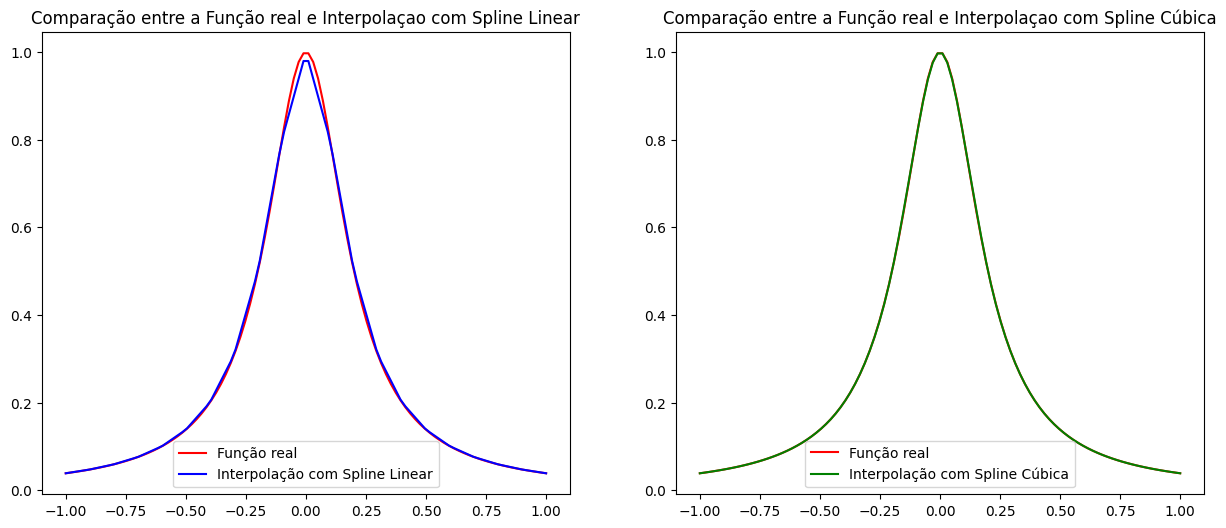

In [106]:
# Gráficos comparando os dois métodos de interpolação
fig, axis = plt.subplots(1, 2, figsize=(15, 6))

axis[0].set_title('Comparação entre a Função real e Interpolaçao com Spline Linear')
axis[0].plot(xTeste, yFuncao, 'r', label='Função real')
axis[0].plot(xTeste, interpLinear(xTeste), 'b', label='Interpolação com Spline Linear')
axis[0].legend()

axis[1].set_title('Comparação entre a Função real e Interpolaçao com Spline Cúbica')
axis[1].plot(xTeste, yFuncao, 'r', label='Função real')
axis[1].plot(xTeste, interpCubica(xTeste), 'g', label='Interpolação com Spline Cúbica')
axis[1].legend()

As splines, particularmente a cúbica, proporcionam uma interpolação mais estável e suave em relação aos polinômios de alta ordem empregados nos métodos de Lagrange e Newton, especialmente quando se trata de muitos pontos igualmente espaçados. Isso torna as splines mais recomendáveis em muitos casos de interpolação prática.

### e)

Os nós de Chebyshev distribuem os pontos mais densamente nas extremidades do intervalo e menos densamente no meio. Isso ajuda a minimizar as oscilações de Runge, tornando a interpolação mais precisa nas extremidades. Dessa forma, verificaremos que as funções que serão obtidas agora serão melhores que as dos itens b e c, já que essas funções têm grandes oscilações nas extremidades, algo que será melhorado com os nós de Chebyshev.

In [88]:
def nos_chebyshev(a, b, n):
    nos = np.array([])

    for i in range(n):
         no = (a+b)/2 + ((b-a) * np.cos(((2*i + 1) * np.pi)/(2*(n+1))))/2
         nos = np.append(nos, no)

    return nos

#### e.b)

In [89]:
# Calculando a interpolação de Newton e Lagrange usando 11 nós de Chebyshev entre -1 e 1
xi = nos_chebyshev(-1, 1, 11)
yi = f(xi)

y11LagrangeCheby = lagrange_interp(xi, yi, xTeste)
y11NewtonCheby = newton_interp(xi, yi, xTeste)

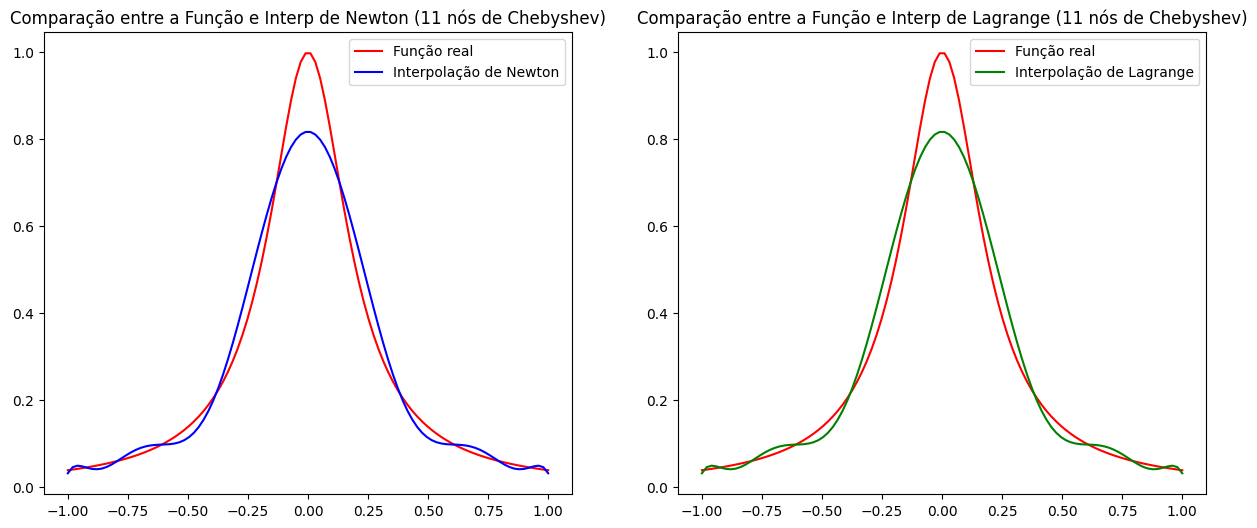

In [90]:
# Gráficos comparando os dois métodos de interpolação
fig, axis = plt.subplots(1, 2, figsize=(15, 6))

axis[0].set_title('Comparação entre a Função e Interp de Newton (11 nós de Chebyshev)')
axis[0].plot(xTeste, yFuncao, 'r', label='Função real')
axis[0].plot(xTeste, y11NewtonCheby, 'b', label='Interpolação de Newton')
axis[0].legend()

axis[1].set_title('Comparação entre a Função e Interp de Lagrange (11 nós de Chebyshev)')
axis[1].plot(xTeste, yFuncao, 'r', label='Função real')
axis[1].plot(xTeste, y11LagrangeCheby, 'g', label='Interpolação de Lagrange')
axis[1].legend()

Assim como no item b, ambas as interpolações (Newton e Lagrange) apresentam o mesmo resultado. No entanto, utilizando-se os nós de Chebyshev percebe-se menos oscilações nas extremidades quando comparamos os novos gráficos com aqueles do item b.

#### e.c)

In [91]:
# Calculando a interpolação de Newton e Lagrange usando 21 nós de Chebyshev entre -1 e 1
xi = nos_chebyshev(-1, 1, 21)
yi = f(xi)

y21LagrangeCheby = lagrange_interp(xi, yi, xTeste)
y21NewtonCheby = newton_interp(xi, yi, xTeste)

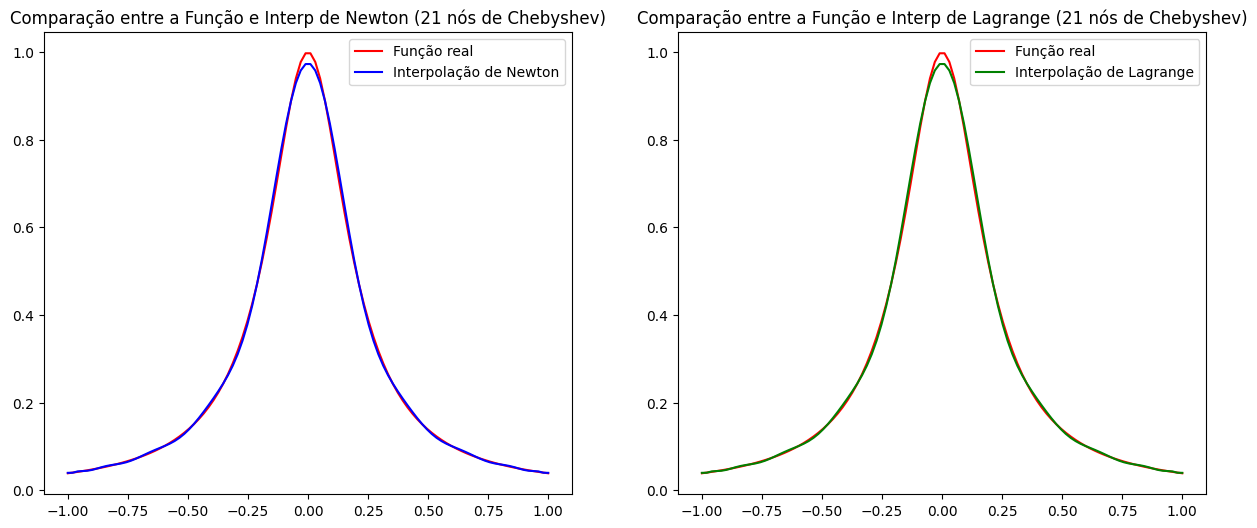

In [92]:
# Gráficos comparando os dois métodos de interpolação
fig, axis = plt.subplots(1, 2, figsize=(15, 6))

axis[0].set_title('Comparação entre a Função e Interp de Newton (21 nós de Chebyshev)')
axis[0].plot(xTeste, yFuncao, 'r', label='Função real')
axis[0].plot(xTeste, y21NewtonCheby, 'b', label='Interpolação de Newton')
axis[0].legend()

axis[1].set_title('Comparação entre a Função e Interp de Lagrange (21 nós de Chebyshev)')
axis[1].plot(xTeste, yFuncao, 'r', label='Função real')
axis[1].plot(xTeste, y21LagrangeCheby, 'g', label='Interpolação de Lagrange')
axis[1].legend()

Assim como no item c, ambas as interpolações (Newton e Lagrange) apresentam o mesmo resultado. No entanto, utilizando-se os nós de Chebyshev percebe-se menos oscilações nas extremidades quando comparamos os novos gráficos com aqueles do item c. Além disso, é possível verificar uma melhorar na aproximação da função quando aumentamos o número de nós, já que, claramente, a função com 21 nós é bem melhor que a com 11 nós.

## Exercício 3

### a)

Os códigos abaixo recebem os dados do eixo X (x) e seus valores correspondentes no eixo Y (y), além do grau do polinômio envolvido (k). Com isso, consegue calcular e retornar os valores dos alphas que serão usados para aproximar a função.

A função mmq e mmq_QR são iguais até um momento, pois o mmq_QR utiliza-se da mmq, mas a modifica no momento em que utiliza a decomposição QR para transformar a matriz X nas Q e R.

MMQ:
$$
\mathbf{X}^{T}\mathbf{X}\alpha^{*} = \mathbf{X}^{T}y
\leftrightarrow
\alpha^{*} = (\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}y
$$

MMQ_QR:
$$
\mathbf{X}^{T}\mathbf{X}\alpha^{*} = \mathbf{X}^{T}y
\leftrightarrow
(\mathbf{Q}\mathbf{R})^{T}(\mathbf{Q}\mathbf{R})\alpha^{*} = (\mathbf{Q}\mathbf{R})^{T}y
$$

$$
\leftrightarrow
\mathbf{R}\alpha^{*} = \mathbf{Q}^{T}y
$$

In [93]:
def mmq(x, y, k):
    # Cria a matriz de Vandermond com a matriz X e grau do polinômio k
    X = np.vander(x, k)

    # Obtendo as matrizes que serão usadas no sistema linear
    A = np.transpose(X).dot(X)
    b = np.transpose(X).dot(y)

    # Resolvendo o sistema 'Aa=b' para encontrar os alphas da função
    a = np.linalg.solve(A, b)

    return a

def mmq_QR(x, y, k):
    # Cria a matriz de Vandermond com a matriz X e grau do polinômio k
    X = np.vander(x, k)

    # Decompondo a matriz X em Q e R.
    Q, R = np.linalg.qr(X)

    # Obtendo as matrizes que serão usadas no sistema linear
    b = np.transpose(Q).dot(y)

    # Resolvendo o sistema 'Ra=b' para encontrar os alphas da função
    a = np.linalg.solve(R, b)


    return a

### b)

In [94]:
# Lendo o arquivo
numeros = []
with open('casosacumuladosbrasilatuaizado.txt', 'r') as file:
    numeros = [int(line.strip()) for line in file]

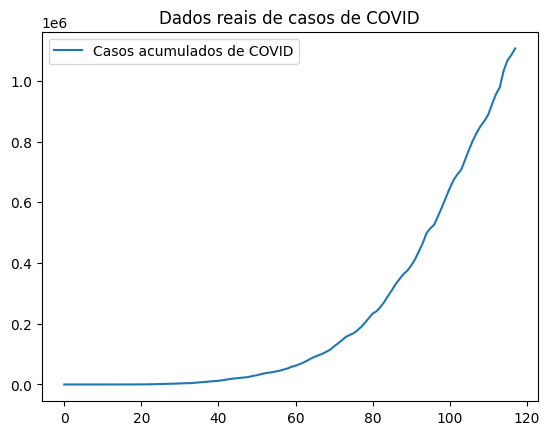

In [95]:
# Gráfico com os dados do arquivo
plt.title('Dados reais de casos de COVID')
plt.plot(np.arange(len(numeros)), numeros, label='Casos acumulados de COVID')
plt.legend()

Como a expressão g(x) dada não é linear, precisamos linearizá-la, para tanto, fazemos:

$$
g(x) = ab^{x}
$$

$$
\leftrightarrow
ln(f(x)) \approx ln(a) 1 + ln(b) x
$$

Substituindo por variáveis:
$$
\leftrightarrow
F(x) \approx \alpha^{x}_{1} \phi_{0} + \alpha^{*}_{1} \phi_{0}
$$

Resolvendo o sistema linear com as variáveis substituídas acima, temos:
$$
\begin{cases}
a = e^{\alpha^{*}_{1}} \\
b = e^{\alpha^{*}_{0}}
\end{cases}
$$

In [96]:
# Obtendo um vetor com os valores do eixo Y após passar pela função ln
logNumeros = []
for n in numeros:
    logNumeros = np.append(logNumeros, np.log(n))

# Calculando o MMQ, logo os alphas
alphas = mmq_QR(np.arange(len(logNumeros)), logNumeros, 2)

In [97]:
# Calculando 'a' e 'b'
a = np.e ** alphas[1]
b = np.e ** alphas[0]

In [98]:
# Função aproximada obtida
def f(x):
    return a * (b ** x)

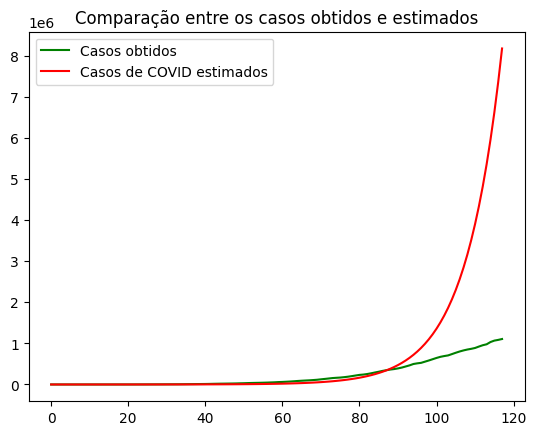

In [99]:
# Gráfico com a comparação entre os dados reais e estimados
eixoX = np.arange(len(numeros))

plt.title('Comparação entre os casos obtidos e estimados')
plt.plot(eixoX, numeros, 'g', label='Casos obtidos')
plt.plot(eixoX, f(eixoX), 'r', label='Casos de COVID estimados')
plt.legend()

### c)

In [100]:
# Repetindo o item b) somente com os 20 primeiros dias
novosAlphas = mmq_QR(np.arange(20), logNumeros[:20], 2)

novoA = np.e ** novosAlphas[1]
novoB = np.e ** novosAlphas[0]

def novoF(x):
    return novoA * (novoB ** x)

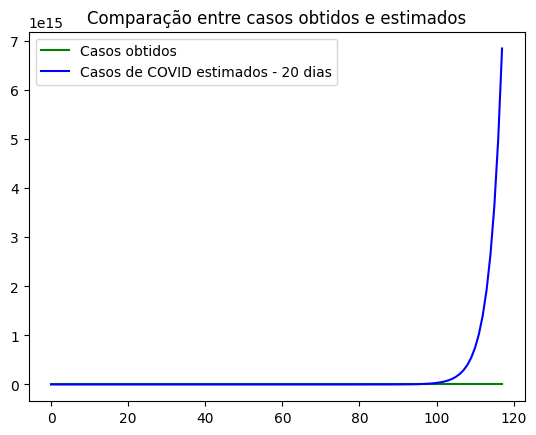

In [101]:
# Gráfico com a comparação entre os dados reais e estimados usando apenas os 20 primeiros dias
eixoX = np.arange(118)

plt.title('Comparação entre casos obtidos e estimados')
plt.plot(eixoX, numeros[:len(eixoX)], 'g', label='Casos obtidos')
plt.plot(eixoX, novoF(eixoX), 'b', label='Casos de COVID estimados - 20 dias')
plt.legend()

### d)

In [102]:
# Repetindo o item b) somente com os 50 últimos dias
outrosAlphas = mmq_QR(np.arange(68,118), logNumeros[-50:], 2)

outroA = np.e ** outrosAlphas[1]
outroB = np.e ** outrosAlphas[0]

def outroF(x):
    return outroA * (outroB ** x)

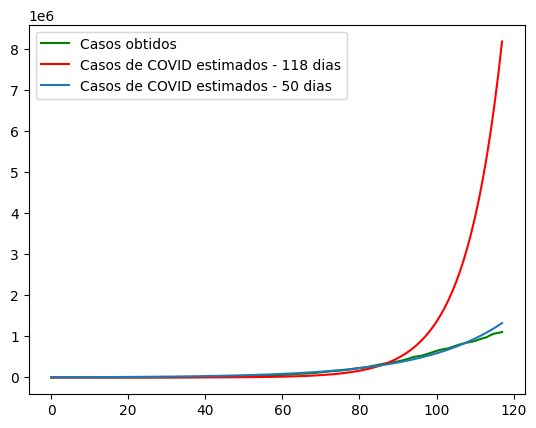

In [103]:
# Gráfico comparando os dados reais, estimados com os 118 dias e os
# estimados usando apenas os 50 últimos dias
eixoX = np.arange(118)

plt.plot(eixoX, numeros[:], 'g', label='Casos obtidos')
plt.plot(eixoX, f(eixoX), 'r', label='Casos de COVID estimados - 118 dias')
plt.plot(eixoX, outroF(eixoX), label='Casos de COVID estimados - 50 dias')

plt.legend()

### e)

Após a execução dos itens anteriores, temos 4 funções, sendo elas:
- Dados reais
- Dados estimados usando todos os 118 dias
- Dados estimados usando os primeiros 20 dias
- Dados estimados usando os últimos 50 dias

Comparando os gráficos obtidos, facilmente observa-se que os dados estimados com os 20 primeiros dias são extremamente exagerados, o que faz sua curva subir muito. Isso ocorre porque nos primeiros dias de pandemia as pessoas não respeitavam muito o lockdown, o que enviesou o MMQ a fazer com que os dados continuassem a crescer rapidamente.

Um outro caso interessante é a curva dada pelos dados estimados com os 50 últimos dias, a qual se ajusta bem aos dados reais, pois, durante esses últimos dias, a população já estava mais ciente dos riscos do vírus e começou a realmente respeitar a quarentena, o que fez a quantidade de casos frear, algo que pode ser visto no gráfico, já que a curva não explode.

Além disso, a curva obtida com a estimação usando os 118 dias também tem dados exagerados, mas não tanto quanto aos dos 20 primeiros dias. Isso ocorre, pois mesmo levando em conta os dados nos quais a quantidade de casos crescia rapidamente (início do período dado), também reconhece o período final, no qual houve um freio na contagem.

Por fim, o que podemos tirar de conclusão disso é que as diferenças nos gráficos obtidos são causadas majoritariamente pela eficiência da quarentena.